In [1]:
from time import time

import numpy as np
import pandas as pd

from spineq.data_fetcher import lad20nm_to_lad20cd
from spineq.optimise import calc_coverage, get_optimisation_inputs, optimise
from spineq.plotting import plot_optimisation_result
from spineq.utils import coverage_matrix

%matplotlib inline

## Parameters

In [2]:
lad20nm = "Newcastle upon Tyne"
lad20cd = lad20nm_to_lad20cd(lad20nm)

n_sensors = 20
theta = 500

population_weight = 1
workplace_weight = 0
pop_age_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 1},
    "pop_children": {"min": 0, "max": 16, "weight": 0},
    "pop_elderly": {"min": 70, "max": 90, "weight": 0},
}

/Users/jroberts/opt/anaconda3/envs/spatial-inequality/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Get Input Data

In [3]:
data = get_optimisation_inputs(
    lad20cd=lad20cd,
    population_weight=population_weight,
    workplace_weight=workplace_weight,
    pop_age_groups=pop_age_groups,
    combine=True,
)

n_locations = len(data["oa_x"])

data.keys()

dict_keys(['oa11cd', 'oa_x', 'oa_y', 'oa_weight'])

## Calculate Coverage Matrix

Based on distances between each pair of output areas

In [4]:
coverage = coverage_matrix(data["oa_x"], data["oa_y"], theta=theta)
coverage

array([[1.00000000e+00, 6.43165972e-01, 1.14852481e-02, ...,
        2.07492231e-06, 2.01653951e-07, 3.86079816e-07],
       [6.43165972e-01, 1.00000000e+00, 1.72128690e-02, ...,
        2.75744405e-06, 2.66921451e-07, 3.35033984e-07],
       [1.14852481e-02, 1.72128690e-02, 1.00000000e+00, ...,
        8.99380461e-05, 8.80452763e-06, 2.79025831e-07],
       ...,
       [2.07492231e-06, 2.75744405e-06, 8.99380461e-05, ...,
        1.00000000e+00, 9.64135097e-02, 1.06796942e-06],
       [2.01653951e-07, 2.66921451e-07, 8.80452763e-06, ...,
        9.64135097e-02, 1.00000000e+00, 4.35129931e-07],
       [3.86079816e-07, 3.35033984e-07, 2.79025831e-07, ...,
        1.06796942e-06, 4.35129931e-07, 1.00000000e+00]])

In [5]:
def make_result_dict(sensors):
    """Convert list of sensors (0/1 array for each OA, 1 if sensor present)
    into result dictionary with format needed for plot_optimisation_result.
    """

    sensors = [
        {"x": data["oa_x"][i], "y": data["oa_y"][i], "oa11cd": data["oa11cd"][i]}
        for i in range(n_locations)
        if sensors[i] == 1
    ]

    oa_weight = pd.Series(data["oa_weight"], index=data["oa11cd"])
    cov = calc_coverage(lad20cd, sensors, oa_weight, theta)

    result = {
        "lad20cd": lad20cd,
        "sensors": sensors,
        "oa_coverage": cov["oa_coverage"],
        "total_coverage": cov["total_coverage"],
    }

    return result

## Baseline 1: Place sensors in output areas with the largest weights

If weight given only to total population, this is equivalent to placing sensors in the output areas with the highest populations.

Time: 0.00s


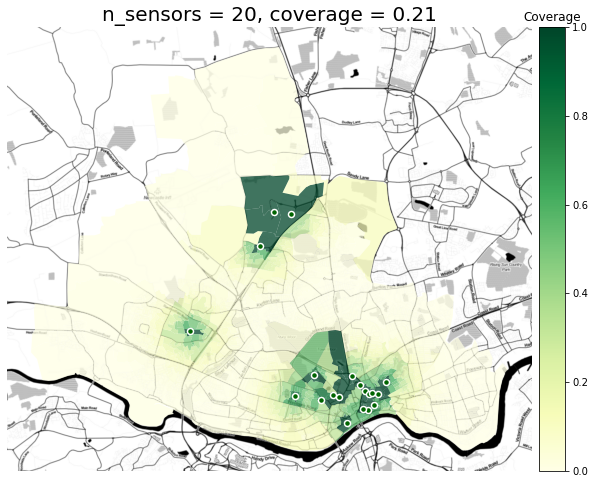

In [6]:
start_time = time()

top_idx = np.argsort(data["oa_weight"])[-n_sensors:]

sensors = np.zeros(n_locations)
sensors[top_idx] = 1

print(f"Time: {time()-start_time:.2f}s")

result = make_result_dict(sensors)

plot_optimisation_result(result)

## Baseline 2: Place sensors in random output areas

Time: 0.00s


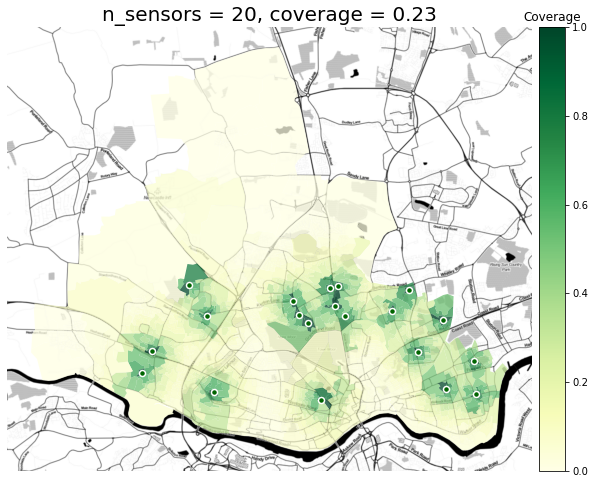

In [7]:
start_time = time()

# add sensors at random location
# (without replacement so sensors all at different locations)
sensors_idx = np.random.choice(
    n_locations,
    size=n_sensors,
    replace=False,
)

sensors = np.zeros(n_locations)
sensors[sensors_idx] = 1

print(f"Time: {time()-start_time:.2f}s")


result = make_result_dict(sensors)
plot_optimisation_result(result)

## Baseline 3: Best of many randomly generated networks

Time: 32.83s


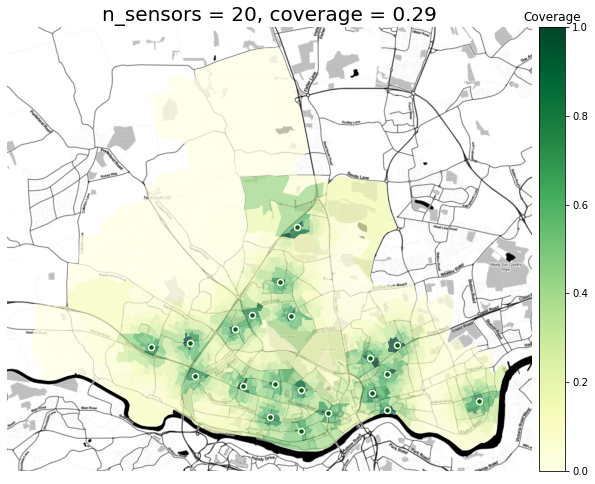

In [8]:
n_attempts = 1000

start_time = time()

best_result = None

for _ in range(n_attempts):
    # add sensors at random location
    # (without replacement so sensors all at different locations)
    sensors_idx = np.random.choice(
        n_locations,
        size=n_sensors,
        replace=False,
    )

    sensors = np.zeros(n_locations)
    sensors[sensors_idx] = 1

    result = make_result_dict(sensors)
    if not best_result or result["total_coverage"] > best_result["total_coverage"]:
        best_result = result

print(f"Time: {time()-start_time:.2f}s")

plot_optimisation_result(best_result)

## Greedy: Place sensors one by one in the place that maximises total coverage

Fetching data...
Placing sensor 1 out of 20 ... coverage = 0.04
Placing sensor 2 out of 20 ... coverage = 0.08
Placing sensor 3 out of 20 ... coverage = 0.10
Placing sensor 4 out of 20 ... coverage = 0.13
Placing sensor 5 out of 20 ... coverage = 0.15
Placing sensor 6 out of 20 ... coverage = 0.17
Placing sensor 7 out of 20 ... coverage = 0.19
Placing sensor 8 out of 20 ... coverage = 0.21
Placing sensor 9 out of 20 ... coverage = 0.23
Placing sensor 10 out of 20 ... coverage = 0.24
Placing sensor 11 out of 20 ... coverage = 0.25
Placing sensor 12 out of 20 ... coverage = 0.27
Placing sensor 13 out of 20 ... coverage = 0.28
Placing sensor 14 out of 20 ... coverage = 0.29
Placing sensor 15 out of 20 ... coverage = 0.30
Placing sensor 16 out of 20 ... coverage = 0.31
Placing sensor 17 out of 20 ... coverage = 0.32
Placing sensor 18 out of 20 ... coverage = 0.33
Placing sensor 19 out of 20 ... coverage = 0.34
Placing sensor 20 out of 20 ... coverage = 0.35
Time (also includes weight and c

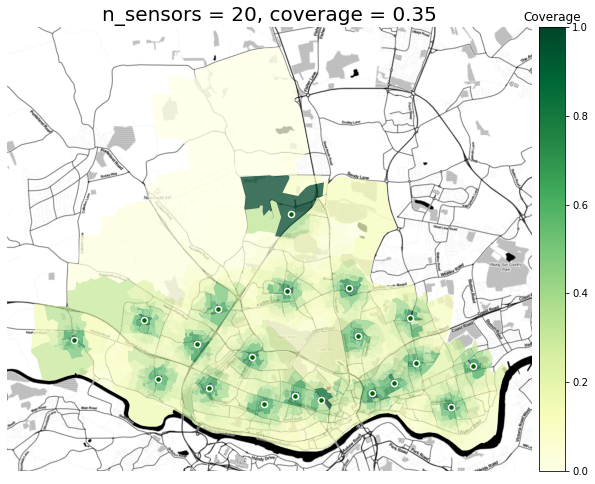

In [9]:
start_time = time()

result = optimise(
    n_sensors=n_sensors,
    theta=theta,
    population_weight=population_weight,
    workplace_weight=workplace_weight,
    pop_age_groups=pop_age_groups,
)

print(f"Time (also includes weight and coverage calculation): {time()-start_time:.2f}s")

plot_optimisation_result(result)

In [10]:
result["total_coverage"]

0.34755221997045344